## Parameters

In [1]:
train_batch_size = 64
val_batch_size = 32
num_workers = 4

num_epochs = 40

size_image = (128, 128)

learning_rate = 0.001 # in some cases - start learning rate

log_dir = './logs'
train_dir = '/home/a_stasiuk/bsuir_ml_part2/data/dogs-vs-cats/train'
test_dir = '/home/a_stasiuk/bsuir_ml_part2/data/dogs-vs-cats/test1'

In [2]:
import pandas as pd
import os
import torch
from torch.utils.tensorboard import SummaryWriter

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Лабораторная №5

### Задание 1.
#### Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.


In [4]:
files_labels = {os.path.join(train_dir, file_name): 0 if 'cat' in file_name else 1 
              for file_name in os.listdir(train_dir)}
data = pd.DataFrame.from_dict({'image_file': list(files_labels.keys()), 'label': list(files_labels.values())})

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2)
test_data, val_data = train_test_split(test_data, test_size=0.25)

### Задание 2.
#### Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. Какое качество классификации получено?

In [6]:
from data_loader import DogCatDataset
from torch.utils.data import DataLoader
from torchvision import transforms


tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size_image),
    transforms.ToTensor()
])
train_dataset = DogCatDataset(train_data, transforms=tfms)
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=train_batch_size, shuffle=True)

# val data
val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size_image),
    transforms.ToTensor()
])
val_dataset = DogCatDataset(val_data, transforms=val_tfms)
val_loader = DataLoader(val_dataset, num_workers=num_workers, batch_size=val_batch_size, shuffle=False)


# test data
test_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size_image),
    transforms.ToTensor()
])
test_dataset = DogCatDataset(test_data, transforms=test_tfms)
test_loader = DataLoader(test_dataset, num_workers=num_workers, batch_size=val_batch_size, shuffle=False)

In [7]:
from cnn_model import CNNModel
import torch.nn as nn
from torch.optim import lr_scheduler


model = CNNModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
logs_writer = SummaryWriter(log_dir='./logs/simple-cnn')

exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 30)

In [8]:
from train_loop import train

train(model, train_loader, test_loader, num_epochs, 
    optimizer, criterion, logs_writer, exp_lr_scheduler, device)

100%|██████████| 40/40 [12:43<00:00, 19.09s/it]


### Задание 3.
#### Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора?

In [9]:
from data_loader import DogCatDataset
from torch.utils.data import DataLoader
from torchvision import transforms


tfms = transforms.Compose([
        transforms.ToPILImage(mode=None),
        transforms.Resize(size_image),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
        transforms.ToTensor(),
    ])

# train data
train_dataset = DogCatDataset(train_data, transforms=tfms)
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=train_batch_size, shuffle=True)

In [10]:
from cnn_model import CNNModel
import torch.nn as nn


model = CNNModel()
criterion = nn.CrossEntropyLoss()

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
logs_writer = SummaryWriter(log_dir='./logs/simple-cnn-augmentations')

exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 30)

In [11]:
from train_loop import train

train(model, train_loader, test_loader, num_epochs, 
    optimizer, criterion, logs_writer, exp_lr_scheduler, device)

100%|██████████| 40/40 [14:06<00:00, 21.17s/it]


### Задание 4.
#### Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него? Какой максимальный результат удалось получить на контрольной выборке?


In [12]:
from data_loader import DogCatDataset
from torch.utils.data import DataLoader
from torchvision import transforms


tfms = transforms.Compose([
        transforms.ToPILImage(mode=None),
        transforms.Resize(size_image),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
        transforms.ToTensor(),
    ])

# train data
train_dataset = DogCatDataset(train_data, transforms=tfms)
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=train_batch_size, shuffle=True)

In [13]:
from torchvision import models
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 30)

logs_writer = SummaryWriter(log_dir='./logs/resnet18-augmentations')

In [14]:
from train_loop import train

train(model, train_loader, val_loader, num_epochs, 
    optimizer, criterion, logs_writer, exp_lr_scheduler, device)

100%|██████████| 40/40 [14:27<00:00, 21.69s/it]


In [15]:
from torchvision import models
from torch.optim import lr_scheduler

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 30)

logs_writer = SummaryWriter(log_dir='./logs/resnet50-augmentations')

In [16]:
from train_loop import train

train(model, train_loader, val_loader, num_epochs, 
    optimizer, criterion, logs_writer, exp_lr_scheduler, device)

100%|██████████| 40/40 [38:19<00:00, 57.48s/it]


In [17]:
logs_writer.close()

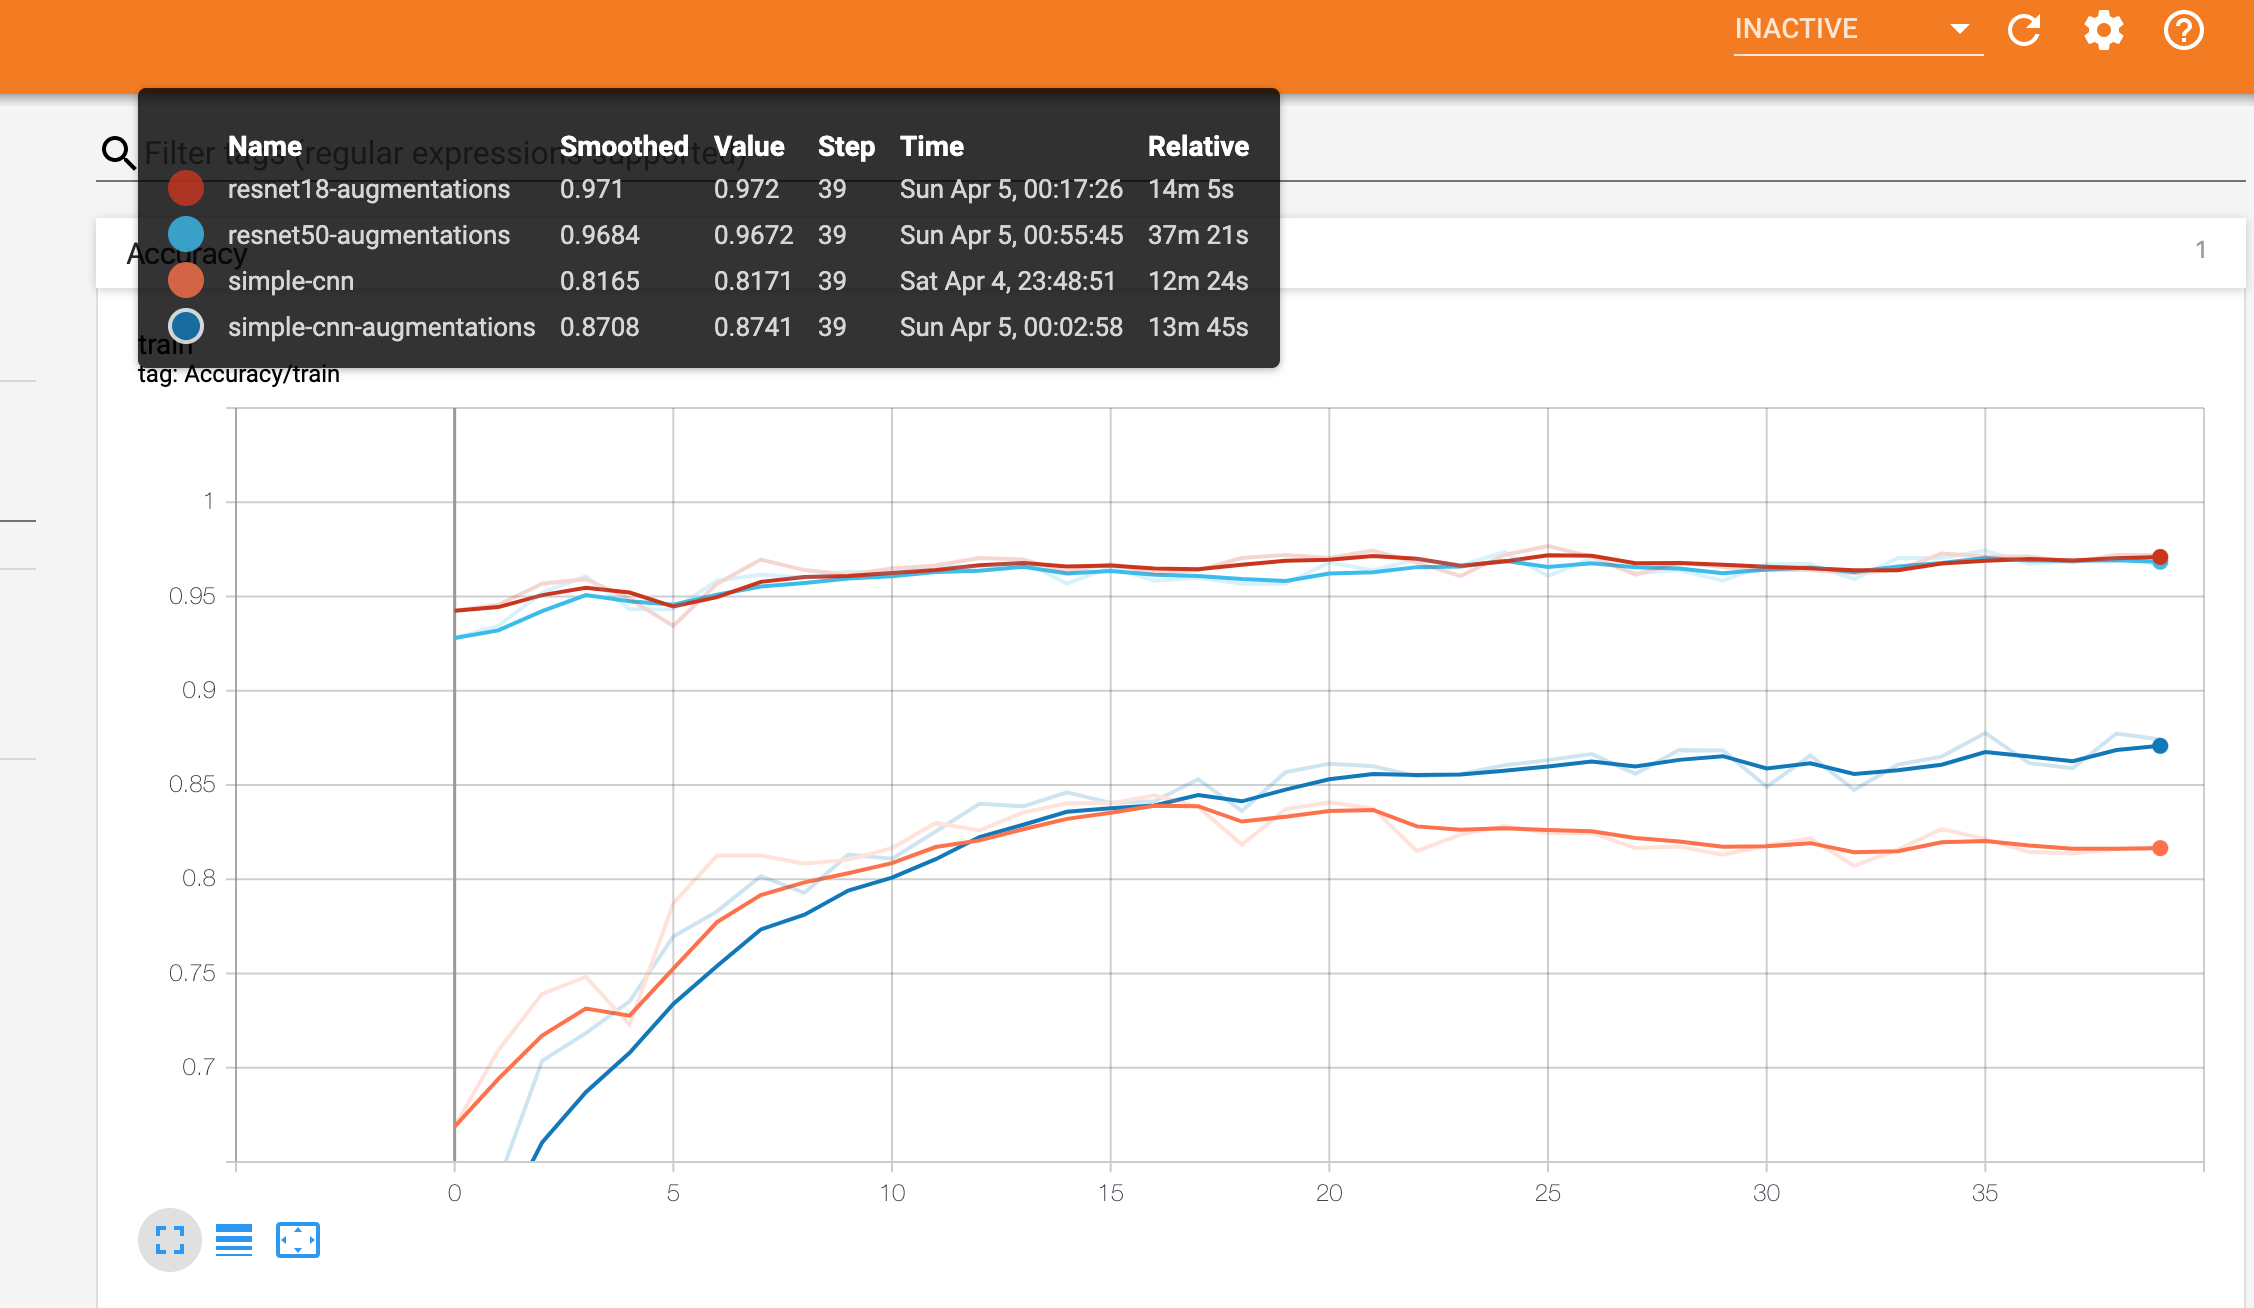

In [3]:
from IPython.display import Image
Image(filename='images/Accuracy.png') 

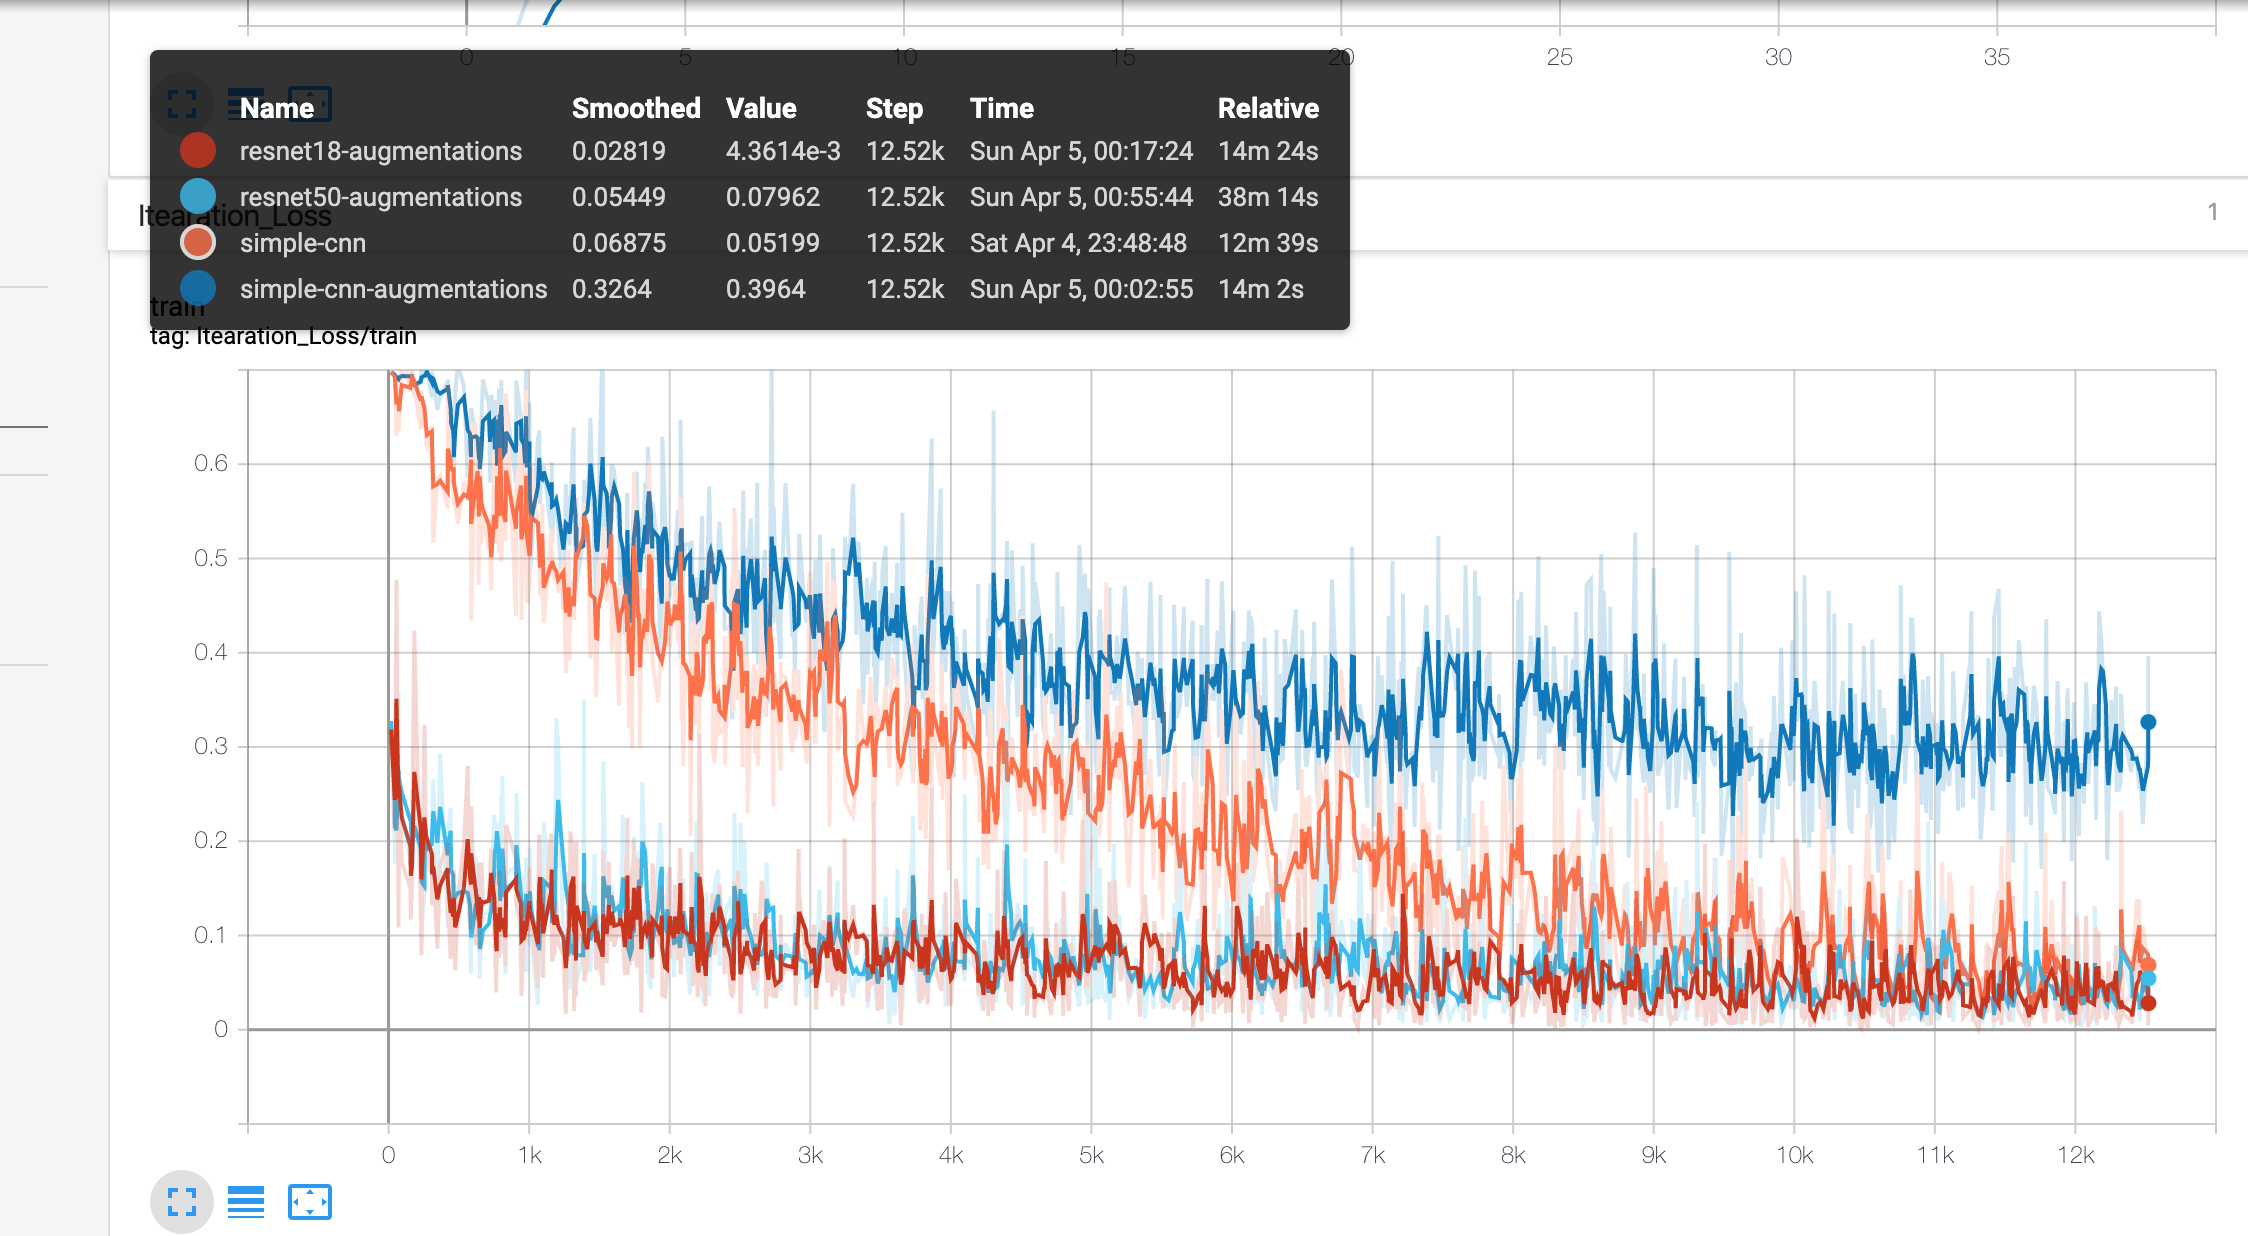

In [4]:
from IPython.display import Image
Image(filename='images/Loss.png') 